# Project Natural Language Processing (NLP)

## Goal:
Develop a predictive model to identify GitHub repository's primary programming language using README file content.

# Imports

In [1]:
# standard imports
import numpy as np
import pandas as pd

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# local imports
import acquire as a
import prepare as p
import lugo_explore as e
# import modeling as m


# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

# Acquire
- Data acquired from GitHub's <a href='https://github.com/search?q=stars%3A%3E0&s=stars&type=Repositories'>the most starred repositories</a>
- It contained 960 rows and 3 columns before cleaning
- Each row represents a repository from GitHub README.md files. 
- Each column contains information from the README files

In [2]:
# acquire data
df = a.get_readmes()

# Data Dictionary

| Feature         | Description                                                                             |
| --------------- | --------------------------------------------------------------------------------------- |
| repo            | The owners/organization and the repository name                                         |
| language        | The most common programming language in the repository                                  |
| top3other       | The top 3 most common programming languages across repositories and the rest are other  |
| readme_contents | The content inside the README.md file                                                   |
| clean           | The content after the prepare phase.                                                    |
| lemmatized      | The clean content after being lemmatized.                                               |

# Prepare
- Removed 379 duplicates
- Didn't rename the columns
- Checked for nulls and removed 37 rows
- Checked that column data types were appropriate for exploration
- Outliers were found but kept them as we felt they were important
- Added a target column named "top3other"
- A new feature was created named "length"
- No encoded categorical variables
- Split data into train, validate, and test (60/20/20), stratifying is 'top3other'
- Scaled was performed on continuous variables
- Cleaned the readme content using normalize, tokenize, stopwords and lemmatize

In [3]:
# preparing data for exploration
df = p.prep_readmes(df)

## Splitting Data

In [4]:
# splitting data in to train, validate, and test
train, validate, test = p.split_data(df, 'top3other', seed=42, test=.2, validate=.25)

## A summary of the data

In [5]:
train.describe()

,repo,language,readme_contents,clean,lemmatized,top3other
count,326,326,326,326,326,326
unique,326,31,326,326,326,4
top,tubalmartin/riloadr,JavaScript,"# Riloadr 1.5.3 - Jul 29, 2014\n\nA cross-brow...",riloadr jul cross browser framework independen...,riloadr jul cross browser framework independen...,other
freq,1,90,1,1,1,138


In [6]:
a.data_summary(train)

data shape: (326, 6)


,data type,#missing,%missing,#unique,count,first_value,second_value
repo,object,0,0.0,326,326,smileyborg/TableViewCellWithAutoLayoutiOS8,taion/scroll-behavior
language,object,0,0.0,31,326,Swift,JavaScript
readme_contents,object,0,0.0,326,326,TableViewCellWithAutoLayoutiOS8\n=============...,# scroll-behavior [![Travis][build-badge]][bui...
clean,object,0,0.0,326,326,tableviewcellwithautolayoutios note sample pro...,scroll behavior travis build badge build npm n...
lemmatized,object,0,0.0,326,326,tableviewcellwithautolayoutios note sample pro...,scroll behavior travis build badge build npm n...
top3other,object,0,0.0,4,326,other,JavaScript


## A brief look at the data

In [7]:
train.head()

,repo,language,readme_contents,clean,lemmatized,top3other
419,tubalmartin/riloadr,JavaScript,"# Riloadr 1.5.3 - Jul 29, 2014\n\nA cross-brow...",riloadr jul cross browser framework independen...,riloadr jul cross browser framework independen...,JavaScript
416,Yalantis/ColorMatchTabs,Swift,# ColorMatchTabs\n\n![cocoapods](https://img.s...,colormatchtabs cocoapods https img shields io ...,colormatchtabs cocoapods http img shield io co...,other
137,lukescott/DraggableCollectionView,Objective-C,DraggableCollectionView\n=====================...,draggablecollectionview extension uicollection...,draggablecollectionview extension uicollection...,Objective-C
244,Zewo/Zewo,Swift,"<p align=""center"">\n <a href=""http://zewo.i...",p aligncenter hrefhttp zewo ioimg srchttps raw...,p aligncenter hrefhttp zewo ioimg srchttps raw...,other
333,neonbjb/tortoise-tts,Python,# TorToiSe\n\nTortoise is a text-to-speech pro...,tortoise tortoise text speech program built fo...,tortoise tortoise text speech program built fo...,other


# Explore

## Question 0: What is the distribution of the target?

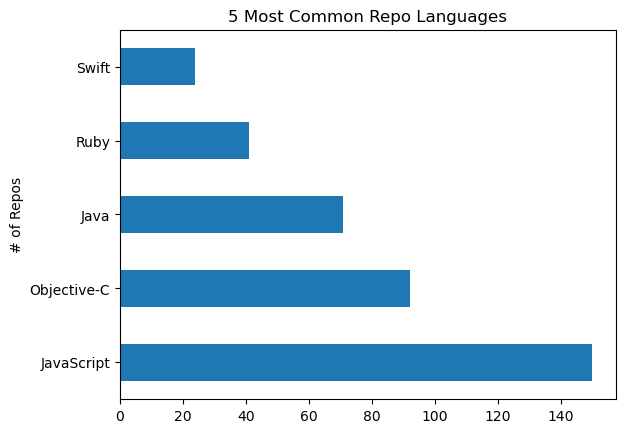

In [8]:
df.language.value_counts().head(5).plot(kind='barh',title='5 Most Common Repo Languages',xlabel='# of Repos',ylabel='Most Common Language in the Repo');

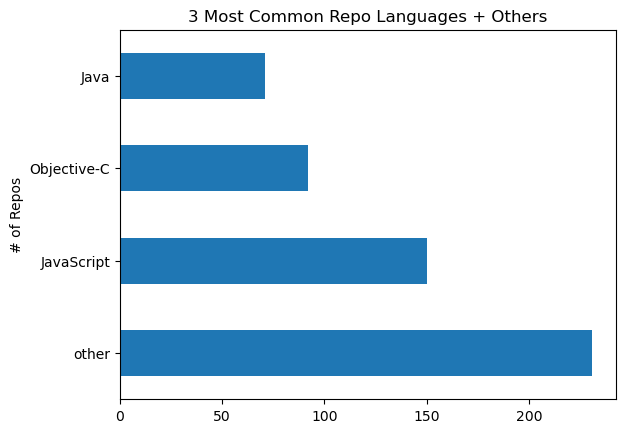

In [9]:
df.top3other.value_counts().plot(kind='barh',title='3 Most Common Repo Languages + Others',xlabel='# of Repos',ylabel='Most Common Language or Other');

## Question 0: What is the distribution of the Split?

In [10]:
df_value_counts = e.get_normalized_value_counts(train, validate, test)
df_value_counts

,train,val,test
other,0.423313,0.431193,0.422018
JavaScript,0.276074,0.275229,0.275229
Objective-C,0.168712,0.165138,0.174312
Java,0.131902,0.128440,0.128440


<div class="alert alert-block alert-info"> 
<b>Initial Explore Summarize</b>

- 

</div>

## Question 1: What are the most common words in READMEs?

In [11]:
all_words = [word for row in df['lemmatized'] for word in row.split()]
len(all_words)

299471

In [12]:
all_freq = pd.Series(all_words).value_counts()
all_freq.head(20)

http       8045
com        6204
github     3831
use        1774
io         1425
j          1413
file       1287
org        1217
code       1135
license    1060
example    1051
www        1019
img         978
master      974
project     939
install     932
using       930
image       928
default     897
name        867
dtype: int64

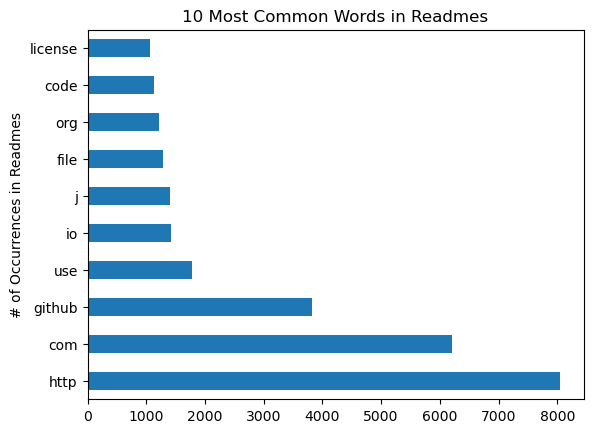

In [13]:
all_freq.head(10).plot(kind='barh',title='10 Most Common Words in Readmes',xlabel='# of Occurrences in Readmes',ylabel='Word');

<div class="alert alert-block alert-info"> 
<b>Question 1 Summarize</b>

- 

</div>

## Question 2: Does the length of the README vary by programming language?

In [14]:
# looking at lemmatized column to stay consistent
# create column based on length of lemmatized readme
train = train.assign(length = train['lemmatized'].str.len())
train

,repo,language,readme_contents,clean,lemmatized,top3other,length
419,tubalmartin/riloadr,JavaScript,"# Riloadr 1.5.3 - Jul 29, 2014\n\nA cross-brow...",riloadr jul cross browser framework independen...,riloadr jul cross browser framework independen...,JavaScript,22938
416,Yalantis/ColorMatchTabs,Swift,# ColorMatchTabs\n\n![cocoapods](https://img.s...,colormatchtabs cocoapods https img shields io ...,colormatchtabs cocoapods http img shield io co...,other,2912
137,lukescott/DraggableCollectionView,Objective-C,DraggableCollectionView\n=====================...,draggablecollectionview extension uicollection...,draggablecollectionview extension uicollection...,Objective-C,1309
244,Zewo/Zewo,Swift,"<p align=""center"">\n <a href=""http://zewo.i...",p aligncenter hrefhttp zewo ioimg srchttps raw...,p aligncenter hrefhttp zewo ioimg srchttps raw...,other,3597
333,neonbjb/tortoise-tts,Python,# TorToiSe\n\nTortoise is a text-to-speech pro...,tortoise tortoise text speech program built fo...,tortoise tortoise text speech program built fo...,other,10201
...,...,...,...,...,...,...,...
240,argerim/select2-rails,Ruby,# Select2 for rails asset pipeline\n\n[Select2...,select rails asset pipeline select https githu...,select rail asset pipeline select http github ...,other,2210
386,graphistry/pygraphistry,Python,# PyGraphistry: Explore Relationships\n\n![Bui...,pygraphistry explore relationships build statu...,pygraphistry explore relationship build status...,other,40175
239,bhavesh-hirpara/MultipleImagePick,Java,# Smart Gallery with Single and Multiple image...,smart gallery single multiple image pick actio...,smart gallery single multiple image pick actio...,Java,1800
217,stripe-archive/react-stripe-elements,JavaScript,## We’ve moved to [@stripe/react-stripe-js](ht...,weve moved stripe react stripe js https github...,weve moved stripe react stripe j http github c...,JavaScript,18807


In [15]:
train.groupby('top3other').length.mean()

top3other
Java           2389.860465
JavaScript     4655.400000
Objective-C    3066.000000
other          4372.282609
Name: length, dtype: float64

In [16]:
train.groupby('top3other').length.median()

top3other
Java           1951.0
JavaScript     3624.0
Objective-C    1930.0
other          2701.0
Name: length, dtype: float64

In [17]:
train.length.median()

2571.0

In [18]:
train[train.length<50000].groupby('top3other').length.mean()

top3other
Java           2389.860465
JavaScript     4655.400000
Objective-C    3066.000000
other          4372.282609
Name: length, dtype: float64

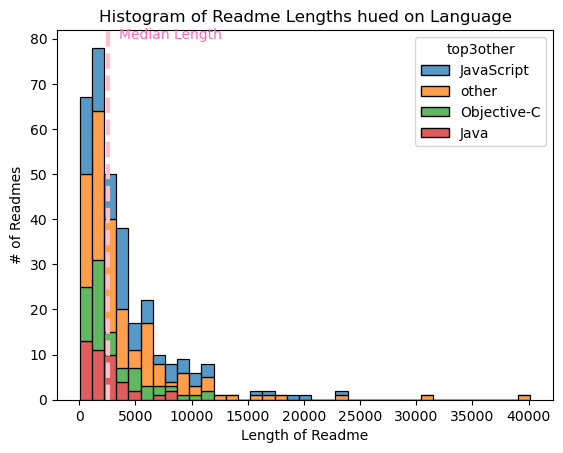

In [19]:
e.plot_readme_lengths(train)

### Analyze feature_x vs target with stats
- $H_0$: There is NO relationship between feature_x and target
- $H_a$: There IS a relationship
- $\alpha$ = .05
    - Utilized the Wilcoxon signed-rank test: it compares two related samples to see if they come from the same distribution. It's a non-parametric alternative to the paired t-test, useful when normal distribution cannot be assumed.

In [20]:
# null hyp Javascript readme lengths are about the same as the population median readme lengths
e.wilcox(train,'top3other','JavaScript','length')

Wilcoxon Test:
 stat = 1150.5, p = 0.0004906479804396669


In [21]:
e.compare_readme_lengths(train, alpha=0.05)

|--------------------------------------|
JavaScript
The readme lengths of JavaScript are significantly different than the population median readme length (p=0.0004906479804396669).
|--------------------------------------|
other
The readme lengths of other are significantly different than the population median readme length (p=0.014225215852737477).
|--------------------------------------|
Objective-C
The readme lengths of Objective-C are NOT significantly different than the population median readme length (p=0.9759587789343889).
|--------------------------------------|
Java
The readme lengths of Java are NOT significantly different than the population median readme length (p=0.07472612576088977).


### Kruskal-Wallis Test
The Kruskal-Wallis test is a nonparametric method for testing whether samples originate from the same distribution. It is used for comparing two or more independent samples of equal or different sample sizes. It extends the Mann-Whitney U test, which is used for comparing only two groups.

In the context of this analysis, we will use the Kruskal-Wallis test to determine if there are statistically significant differences in the lengths of README files across different programming languages.


- $H_0$: The distributions of README lengths are the same across all programming languages.
- $H_a$: At least one programming language has a different distribution of README lengths compared to the others.

The Kruskal-Wallis test will compare the median ranks of README lengths across the different programming languages. If the p-value is less than the chosen significance level (typically 0.05), we reject the null hypothesis and conclude that at least one programming language has a significantly different distribution of README lengths. If the p-value is greater than the significance level, we fail to reject the null hypothesis and conclude that there is not enough evidence to say that the distributions of README lengths are different across the programming languages.

In [22]:
from scipy.stats import kruskal

# Assuming 'train' is a DataFrame with 'length' and 'language' columns
# 'length' contains the lengths of README files
# 'top3other' contains the corresponding programming language of each README file

# Get a list of unique languages
languages = train['top3other'].unique()

# Create a list to store the lengths of README files for each language
lengths = [train[train['top3other'] == lang]['length'] for lang in languages]

# Perform the Kruskal-Wallis test
stat, p = kruskal(*lengths)

# Print the result
if p < 0.05:
    print('There is a statistically significant difference in README lengths across the programming languages.')
else:
    print('There is no statistically significant difference in README lengths across the programming languages.')

There is a statistically significant difference in README lengths across the programming languages.


<div class="alert alert-block alert-info"> 
<b>Question 2 Summarize</b>

- p is < $\alpha$, so we can reject the $H_a$ which suggest the $H_0$

</div>

## Question 3: Do different programming languages use a different number of unique words?

In [23]:
javascript, java, objective_c, other, all_words = e.count_unique_words_by_language(train)

JavaScript unique words: 7336
Java unique words: 2825
Objective-C unique words: 4045
Other unique words: 10915
All unique words: 18611


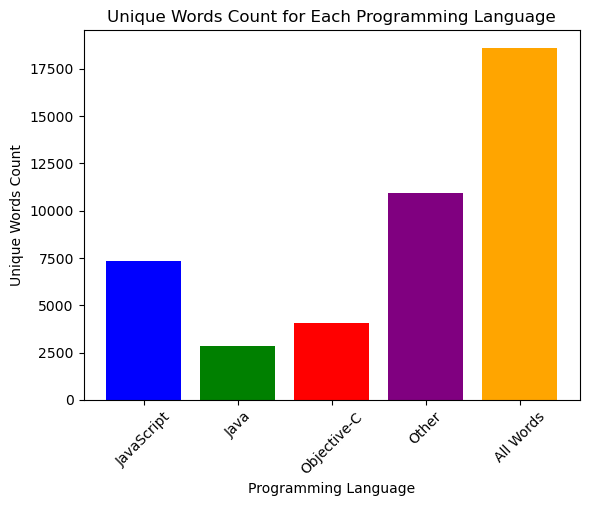

In [24]:
e.plot_unique_words_count(javascript, java, objective_c, other, all_words)

<div class="alert alert-block alert-info"> 
<b>Question 3 Summarize</b>

- These results suggest that the vocabulary used in README files can vary significantly depending on the programming language. The "other" category and JavaScript projects tend to use a wider range of vocabulary, while Java projects use a more limited set of words. This could be due to a variety of factors, including the complexity of the projects, the conventions of the programming language community, or the personal style of the authors.

</div>

## Question 4: Are there any words that uniquely identify a programming language?

In [25]:
unique_word_dicts = e.analyze_unique_words(javascript, java, objective_c, other)
uni_javascript = unique_word_dicts[0]
uni_java = unique_word_dicts[1]
uni_objective_c = unique_word_dicts[2]
uni_other = unique_word_dicts[3]

In [26]:
df = e.conv_dict_to_df(unique_word_dicts)
df.sort_values(by='uni_javascript', ascending=False).head(20)

,uni_javascript,uni_java,uni_objective_c,uni_other
j,701.0,NaN,NaN,NaN
react,319.0,NaN,NaN,NaN
npm,318.0,NaN,NaN,NaN
function,302.0,NaN,NaN,NaN
option,295.0,NaN,NaN,NaN
default,268.0,NaN,NaN,NaN
data,267.0,NaN,NaN,279.0
image,260.0,55.0,101.0,NaN
name,251.0,NaN,NaN,NaN
example,251.0,NaN,85.0,290.0


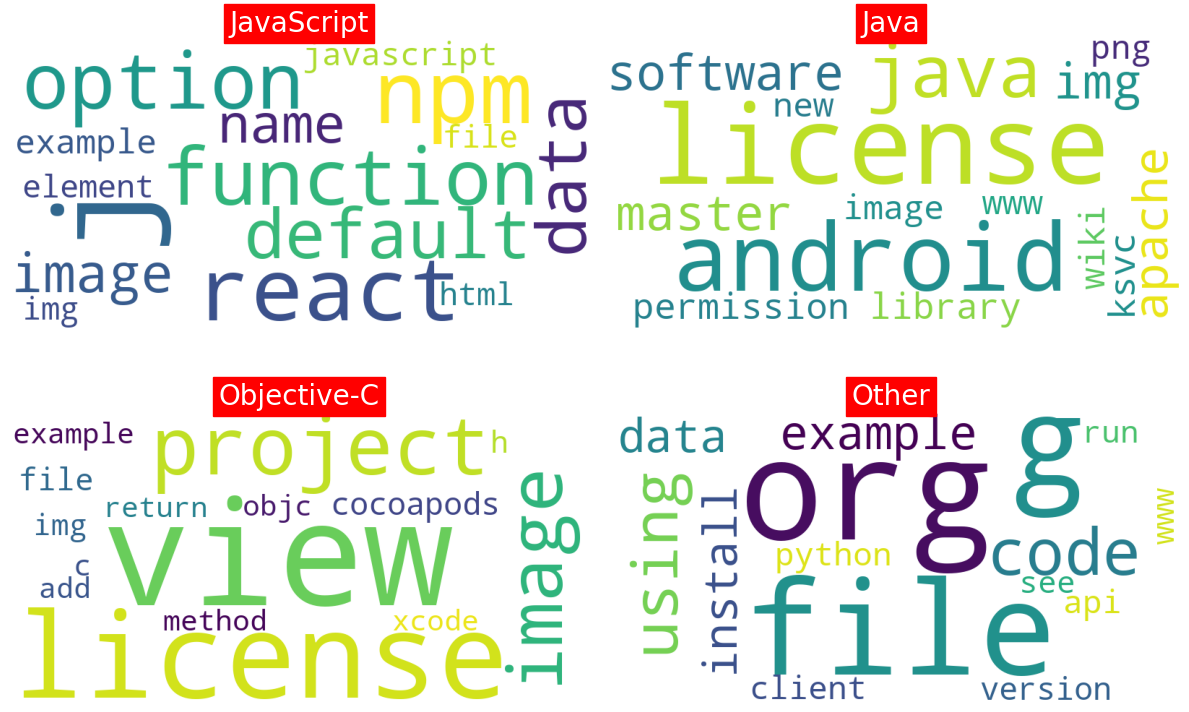

In [27]:
e.create_word_clouds(uni_javascript, uni_java, uni_objective_c, uni_other)

<div class="alert alert-block alert-info"> 
<b>Question 4 Summarize</b>

- 

</div>

## Exploration Summary
* Plain English bullets as required

* Features that have a relationship with target (stats test for feature_y, feature_z, etc. completed on separate working notebook:
    * feature x ...
    * feature y
    * feature z


<div class="alert alert-block alert-success"> 
<b>Features moving to modeling</b>

- ALL

</div>

# Modeling
* Evaluation Metrics (example: I will use R^2 and Root Mean Square Error (RMSE) as my evaluation metrics)
    * for R^2, the value is in the range 0-1; closer to 1.0 is better; baseline is 0.0
    * for RMSE, the lower the value the better; baseline is xxx
* The average target is xxx which is the baseline prediction
* I will evaluate x different model types and various hyperparameter configurations
    * (Example: The four model types are Ordinary Least Squares (OLS), LassoLars, Polynomial Regression, Generalized Linear Model (GLM))
* Models will be evaluated on train and validate data
* The model that performs the best will then be evaluated on test

In [28]:
## prep data for modeling
## INSERT CODE HERE (examples below

# scaling continuous variable columns for use in modeling
# to_scale = ['bathrooms', 'bedrooms', 'squarefeet', 'lotsize_sqft', 'year']
# train_scaled, validate_scaled, test_scaled = w.get_minmax_scaled(train, validate, test, to_scale)

# get X y splits for modeling
# X_train_scaled, X_validate_scaled, X_test_scaled, y_train, y_validate, y_test = m.get_X_y_baseline(train_scaled, validate_scaled, test_scaled)

## Model Name (example: Ordinary Least Squares (OLS) Regression)

In [29]:
# get model results
# INSERT CODE HERE

* model name did/did not beat baseline

## Model Name (example: LassoLars)

In [30]:
# get model results
# INSERT CODE HERE

* model name did/did not beat baseline

## Model Name (example: Polynomial Regression)

In [31]:
# get model results
# INSERT CODE HERE

* model name did/did not beat baseline

## Model Name (example: Generalized Linear Model (GLM))

In [32]:
# get model results
# INSERT CODE HERE

* model name did/did not beat baseline

## Comparing Models
* summarize the model performance
* ...
* I have chosen to move forward with the ___ model on test

## Best Model (model name) on Test

In [33]:
# get test results for final model
# INSERT CODE HERE

In [34]:
# maybe a visual of model performance (like a residual plot for a regression model)

## Modeling Summary
* summary bullet 1 ...

# Conclusions

## Exploration
* bullets

## Modeling
* bullets

## Recommendations
* bullets

## Next steps
* bullets